First, import libraries and create a path to the saved file containing our data. Create a cursor to make a connection to the database 

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
import sqlite3 
import matplotlib.pyplot as plt

path = '/Users/danielkim/Documents/IndependentProjects/Euro Soccer Analysis/' # saved into my local directory
database = path + 'database.sqlite' # filename

conn = sqlite3.connect(database) # established connection to database

Explore database for tables,fields/features, and records.

In [2]:
#list tables
tables = pd.read_sql("""select * from sqlite_master where type = 'table';""", conn)
print(tables) # database structure

    type               name           tbl_name  rootpage  \
0  table    sqlite_sequence    sqlite_sequence         4   
1  table  Player_Attributes  Player_Attributes        11   
2  table             Player             Player        14   
3  table              Match              Match        18   
4  table             League             League        24   
5  table            Country            Country        26   
6  table               Team               Team        29   
7  table    Team_Attributes    Team_Attributes         2   

                                                 sql  
0             CREATE TABLE sqlite_sequence(name,seq)  
1  CREATE TABLE "Player_Attributes" (\n\t`id`\tIN...  
2  CREATE TABLE `Player` (\n\t`id`\tINTEGER PRIMA...  
3  CREATE TABLE `Match` (\n\t`id`\tINTEGER PRIMAR...  
4  CREATE TABLE `League` (\n\t`id`\tINTEGER PRIMA...  
5  CREATE TABLE `Country` (\n\t`id`\tINTEGER PRIM...  
6  CREATE TABLE "Team" (\n\t`id`\tINTEGER PRIMARY...  
7  CREATE TABLE `Te

The database has 7 tables. The titles of the tables are self-explanatory except for sqlite_sequence. sqlite_sequence contains information on the number of entries/records for the other 6 tables.

In [3]:
#list countries
countries = pd.read_sql("select * from Country;", conn)
# type(countries)
print(countries)

       id         name
0       1      Belgium
1    1729      England
2    4769       France
3    7809      Germany
4   10257        Italy
5   13274  Netherlands
6   15722       Poland
7   17642     Portugal
8   19694     Scotland
9   21518        Spain
10  24558  Switzerland


In [4]:
# list leagues
leagues = pd.read_sql("select country_id, l.name as league, c.name as country from League l join Country c on c.id = l.id;", conn)
print(leagues)

    country_id                    league      country
0            1    Belgium Jupiler League      Belgium
1         1729    England Premier League      England
2         4769            France Ligue 1       France
3         7809     Germany 1. Bundesliga      Germany
4        10257             Italy Serie A        Italy
5        13274    Netherlands Eredivisie  Netherlands
6        15722        Poland Ekstraklasa       Poland
7        17642  Portugal Liga ZON Sagres     Portugal
8        19694   Scotland Premier League     Scotland
9        21518           Spain LIGA BBVA        Spain
10       24558  Switzerland Super League  Switzerland


The number of records in the League table match the number of records in the Country table.

In [5]:
# list years for which data were collected
years = pd.read_sql("select season from Match group by season;", conn)
print(years)

      season
0  2008/2009
1  2009/2010
2  2010/2011
3  2011/2012
4  2012/2013
5  2013/2014
6  2014/2015
7  2015/2016


We are dealing with 7 years worth of data for season starting 2008/2009 and ending 2015/2016.

In [35]:
# list country, season, stages, # of teams, away goals, home goals, total goals for each league and season
leagues_by_season = pd.read_sql("""select Country.name as country_name, League.name as league_name,
                                season, count(distinct stage) as number_of_stages,
                                count(distinct HT.team_long_name) as number_of_teams,
                                avg(home_team_goal) as avg_home_team_goals, avg(away_team_goal) as avg_away_team_goals,
                                avg(home_team_goal - away_team_goal) as avg_goal_diff, avg(home_team_goal + away_team_goal) as avg_goals,
                                sum(home_team_goal + away_team_goal) as total_goals 
                                from Match join Country on Country.id = Match.country_id
                                join League on League.id = Match.league_id
                                left join Team as HT on HT.team_api_id = Match.home_team_api_id
                                left join Team as AT on AT.team_api_id = Match.away_team_api_id
                                where country_name in ('Spain', 'Germany', 'France', 'Italy', 'England')
                                group by Country.name, League.name, season
                                having count(distinct stage) > 10
                                order by Country.name, League.name, season desc;""", conn)
print(leagues_by_season)

   country_name             league_name     season  number_of_stages  \
0       England  England Premier League  2015/2016                38   
1       England  England Premier League  2014/2015                38   
2       England  England Premier League  2013/2014                38   
3       England  England Premier League  2012/2013                38   
4       England  England Premier League  2011/2012                38   
5       England  England Premier League  2010/2011                38   
6       England  England Premier League  2009/2010                38   
7       England  England Premier League  2008/2009                38   
8        France          France Ligue 1  2015/2016                38   
9        France          France Ligue 1  2014/2015                38   
10       France          France Ligue 1  2013/2014                38   
11       France          France Ligue 1  2012/2013                38   
12       France          France Ligue 1  2011/2012              

<Axes: title={'center': 'Average Goals per Game Over Time'}, xlabel='season', ylabel='avg. goal'>

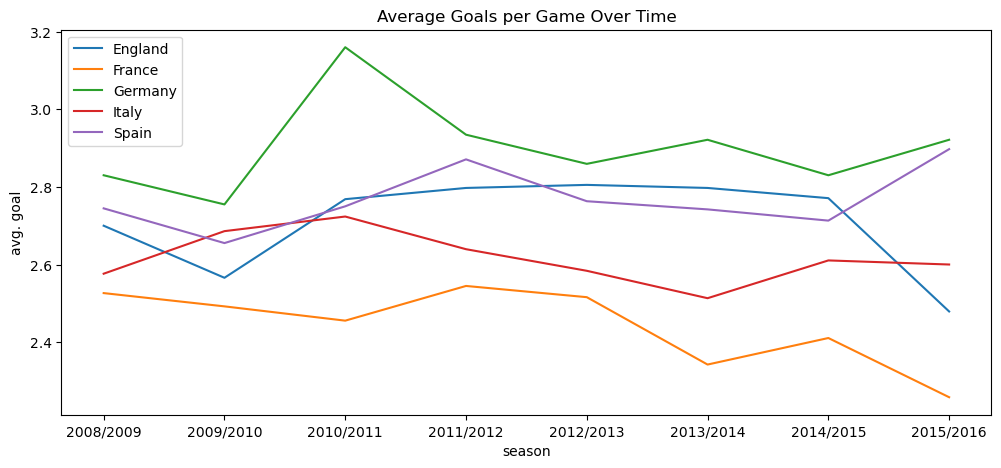

In [22]:
df = pd.DataFrame(index=np.sort(leagues_by_season['season'].unique()), columns=leagues_by_season['country_name'].unique())

df.loc[:,'Germany'] = list(leagues_by_season.loc[leagues_by_season['country_name']=='Germany','avg_goals'])
df.loc[:,'Spain']   = list(leagues_by_season.loc[leagues_by_season['country_name']=='Spain','avg_goals'])
df.loc[:,'France']   = list(leagues_by_season.loc[leagues_by_season['country_name']=='France','avg_goals'])
df.loc[:,'Italy']   = list(leagues_by_season.loc[leagues_by_season['country_name']=='Italy','avg_goals'])
df.loc[:,'England']   = list(leagues_by_season.loc[leagues_by_season['country_name']=='England','avg_goals'])

df.plot(figsize=(12,5),title='Average Goals per Game Over Time', xlabel = 'season', ylabel = 'avg. goal')

As seen in the line graph above, teams in the German league scored more goals per game, on average. On the other hand, teams in the French league had the least success in scoring goals per game, on average. 

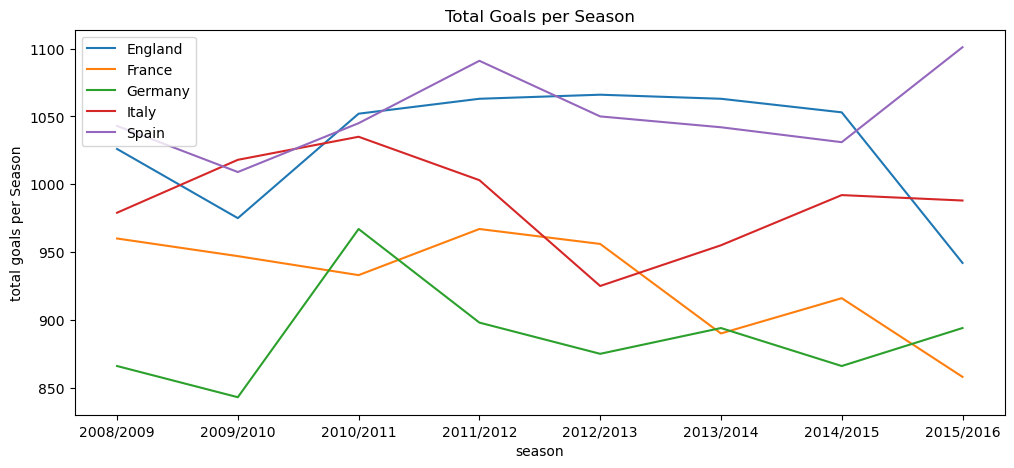

In [31]:
df2 = pd.DataFrame(index=np.sort(leagues_by_season['season'].unique()), columns=leagues_by_season['country_name'].unique())


df2.loc[:,'Germany'] = list(leagues_by_season.loc[leagues_by_season['country_name']=='Germany','total_goals'])
df2.loc[:,'Spain']   = list(leagues_by_season.loc[leagues_by_season['country_name']=='Spain','total_goals'])
df2.loc[:,'France']   = list(leagues_by_season.loc[leagues_by_season['country_name']=='France','total_goals'])
df2.loc[:,'Italy']   = list(leagues_by_season.loc[leagues_by_season['country_name']=='Italy','total_goals'])
df2.loc[:,'England']   = list(leagues_by_season.loc[leagues_by_season['country_name']=='England','total_goals'])

df2.plot(figsize=(12,5),title='Total Goals per Season', xlabel='season', ylabel='total goals per Season')
plt.legend(loc='upper left')

Interestingly, teams in the German league scored the least number of goals during the season than any leagues in other countries except for a few years (2010/2011, 2013/2014, 2015/2016). At first, I expected to see the highest total goals per season for the German league given the league's high average goals scored per game. However, the dataset also showed that teams in the German league play 4 less games than teams in the EPL with their shorter seasons, as illustrated by the 'number of stages' attribute. Otherwise, the leagues in England or Spain consistently had the most goals per season except for the 2009/2010 season when the league in Italy barely edged out in front of the Spanish league.

<Axes: title={'center': 'Average Goals Difference Home vs Out'}, xlabel='season', ylabel='avg. goal differential'>

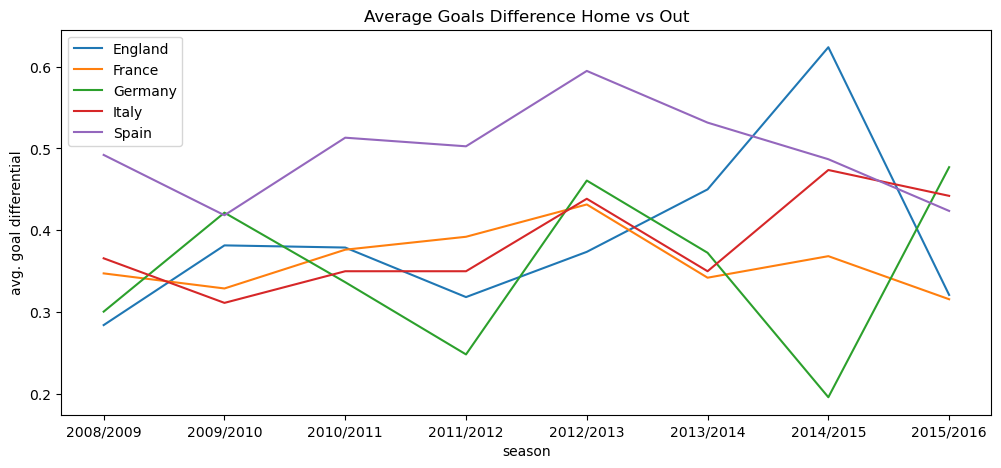

In [20]:
df1 = pd.DataFrame(index=np.sort(leagues_by_season['season'].unique()), columns=leagues_by_season['country_name'].unique())


df1.loc[:,'Germany'] = list(leagues_by_season.loc[leagues_by_season['country_name']=='Germany','avg_goal_diff'])
df1.loc[:,'Spain']   = list(leagues_by_season.loc[leagues_by_season['country_name']=='Spain','avg_goal_diff'])
df1.loc[:,'France']   = list(leagues_by_season.loc[leagues_by_season['country_name']=='France','avg_goal_diff'])
df1.loc[:,'Italy']   = list(leagues_by_season.loc[leagues_by_season['country_name']=='Italy','avg_goal_diff'])
df1.loc[:,'England']   = list(leagues_by_season.loc[leagues_by_season['country_name']=='England','avg_goal_diff'])

df1.plot(figsize=(12,5),title='Average Goals Difference Home vs Out', xlabel='season', ylabel='avg. goal differential')

Although the German league had the highest average goals per game, the Spanish league consistently had the highest average goal differential in the same timeframe. This meant that home teams normally had the advantage as they usually found more success in scoring goals than the away team had when visiting the home team. 

In [17]:
players_height = pd.read_sql("""select case
                                        when round(height)<165 then 165
                                        when round(height)>195 then 195
                                        else round(height)
                                        end as calc_height, 
                                        count(height) as distribution, 
                                        (avg(PA_Grouped.avg_overall_rating)) as avg_overall_rating,
                                        (avg(PA_Grouped.avg_potential)) as avg_potential,
                                        avg(weight) AS avg_weight 
                            from Player
                            left join (select Player_Attributes.player_api_id, 
                                        avg(Player_Attributes.overall_rating) as avg_overall_rating,
                                        avg(Player_Attributes.potential) as avg_potential  
                                        from Player_Attributes
                                        group by Player_Attributes.player_api_id) 
                                        as PA_Grouped on PLAYER.player_api_id = PA_Grouped.player_api_id
                            group by calc_height
                            order by calc_height
                                ;""", conn)
players_height


,calc_height,distribution,avg_overall_rating,avg_potential,avg_weight
0,165.0,74,67.365543,73.327754,139.459459
1,168.0,118,67.500518,73.124182,144.127119
2,170.0,403,67.726903,73.379056,147.799007
3,173.0,530,66.980272,72.848746,152.824528
4,175.0,1188,66.805204,72.258774,156.111953
5,178.0,1489,66.367212,71.943339,160.665547
6,180.0,1388,66.419053,71.846394,165.261527
7,183.0,1954,66.634380,71.754555,170.167861
8,185.0,1278,66.928964,71.833475,174.636933
9,188.0,1305,67.094253,72.151949,179.278161


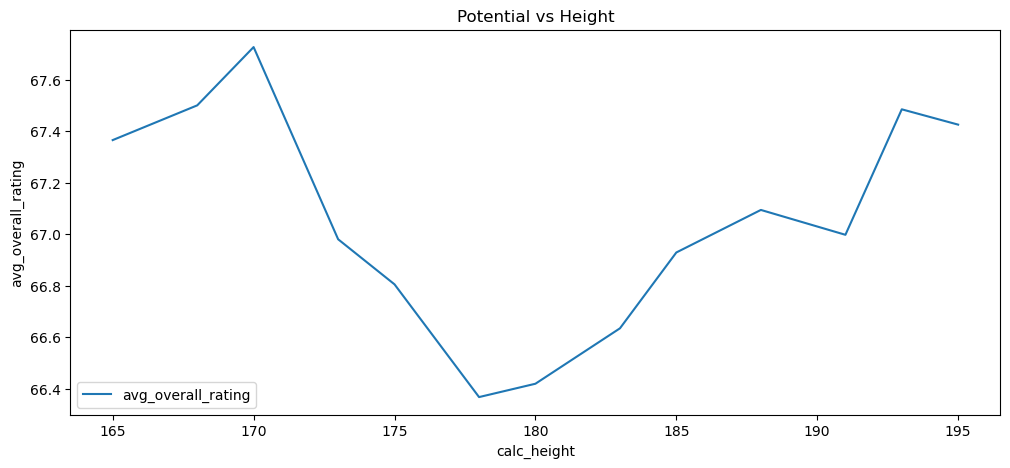

In [33]:
players_height.plot(x='calc_height',y='avg_overall_rating',figsize=(12,5),title='Potential vs Height', ylabel = 'avg_overall_rating').legend(loc = 'lower left')

In [6]:
#list teams by team_fifa_api_id, team_long_name in asc order
teams = pd.read_sql("select * from Team order by team_fifa_api_id, team_long_name limit 20;", conn)
print(teams)

       id  team_api_id  team_fifa_api_id                team_long_name  \
0   35291        10213               NaN                       Amadora   
1   26561         6601               NaN                   FC Volendam   
2       9         7947               NaN                 FCV Dender EH   
3   36723         4064               NaN                      Feirense   
4   51606         7896               NaN                        Lugano   
5   36248         9765               NaN                  Portimonense   
6   34816       177361               NaN  Termalica Bruk-Bet Nieciecza   
7   38791       188163               NaN                       Tondela   
8   35286         7992               NaN                      Trofense   
9      15         4049               NaN                        Tubize   
10  38789         6367               NaN              Uniao da Madeira   
11   3459         9825               1.0                       Arsenal   
12   3465        10252               2

A few teams have no team_fifa_api_id; however, these teams will be omitted as I want to analyse team performance for bigger, well-known teams.

In [7]:
leicester = pd.read_sql("select * from Team where team_long_name = 'Leicester City';", conn)
print(leicester)

     id  team_api_id  team_fifa_api_id  team_long_name team_short_name
0  8021         8197                95  Leicester City             LEI


In 2015/2016, Leicester City won the Premier League (EPL). Leicester City was a team that had been recently promoted from the Championship, which is the second-tier league right below the EPL. We are interested in looking at data for this team from that season.

In [8]:
#list all matches for Leicester City
detailed_matches = pd.read_sql("""select Match.id, season, date(date) as match_date, HT.team_long_name as home_team, AT.team_long_name as away_team
                               from Match
                               LEFT JOIN Team AS HT on HT.team_api_id = Match.home_team_api_id
                               LEFT JOIN Team AS AT on AT.team_api_id = Match.away_team_api_id
                               where HT.team_long_name = 'Leicester City' or AT.team_long_name = 'Leicester City' order by date;""", conn)
print(detailed_matches)

      id     season  match_date          home_team          away_team
0   4011  2014/2015  2014-08-16     Leicester City            Everton
1   4120  2014/2015  2014-08-23            Chelsea     Leicester City
2   4232  2014/2015  2014-08-31     Leicester City            Arsenal
3   4336  2014/2015  2014-09-13         Stoke City     Leicester City
4   4342  2014/2015  2014-09-21     Leicester City  Manchester United
..   ...        ...         ...                ...                ...
71  4663  2015/2016  2016-04-17     Leicester City    West Ham United
72  4672  2015/2016  2016-04-24     Leicester City       Swansea City
73  4682  2015/2016  2016-05-01  Manchester United     Leicester City
74  4692  2015/2016  2016-05-07     Leicester City            Everton
75  4700  2015/2016  2016-05-15            Chelsea     Leicester City

[76 rows x 5 columns]


Leicester City has data for the 2014/2015 and 2015/2016 seasons.

In [9]:
# list season, away goals, home goals, total goals for each season
all_leicester_games = pd.read_sql("""select season,
                                HT.team_long_name as home_team, AT.team_long_name as away_team,
                                home_team_goal, away_team_goal, (home_team_goal + away_team_goal) as total_goals
                                from Match
                                left join Team as HT on HT.team_api_id = Match.home_team_api_id
                                left join Team as AT on AT.team_api_id = Match.away_team_api_id
                                where HT.team_long_name = 'Leicester City' or AT.team_long_name = 'Leicester City'
                                order by season, date
                                ;""", conn)
print(all_leicester_games)

       season          home_team          away_team  home_team_goal  \
0   2014/2015     Leicester City            Everton               2   
1   2014/2015            Chelsea     Leicester City               2   
2   2014/2015     Leicester City            Arsenal               1   
3   2014/2015         Stoke City     Leicester City               0   
4   2014/2015     Leicester City  Manchester United               5   
..        ...                ...                ...             ...   
71  2015/2016     Leicester City    West Ham United               2   
72  2015/2016     Leicester City       Swansea City               4   
73  2015/2016  Manchester United     Leicester City               1   
74  2015/2016     Leicester City            Everton               3   
75  2015/2016            Chelsea     Leicester City               1   

    away_team_goal  total_goals  
0                2            4  
1                0            2  
2                1            2  
3          

As seen in all_leicester_games, Leicester City only had data for two seasons because they had only recently been promoted to the EPL. Thus, we will compare the two season to determine variable changes that could have contributed to the team's success in their 2015/2015 campaign.

In [10]:
# list season, away teams' goals, Leicester City home goals, total goals for each game in each season
leicester_home = pd.read_sql("""select season as Season,
                                AT.team_long_name as 'Away Team',
                                home_team_goal as 'Leicester City', away_team_goal as 'Away Goal',
                                (home_team_goal - away_team_goal) as 'Goal Diff'
                                from Match
                                left join Team as HT on HT.team_api_id = Match.home_team_api_id
                                left join Team as AT on AT.team_api_id = Match.away_team_api_id
                                where HT.team_long_name = 'Leicester City'
                                ;""", conn)
print(leicester_home)

       Season             Away Team  Leicester City  Away Goal  Goal Diff
0   2014/2015               Everton               2          2          0
1   2014/2015  West Bromwich Albion               0          1         -1
2   2014/2015            Sunderland               0          0          0
3   2014/2015             Liverpool               1          3         -2
4   2014/2015       Manchester City               0          1         -1
5   2014/2015     Tottenham Hotspur               1          2         -1
6   2014/2015           Aston Villa               1          0          1
7   2014/2015            Stoke City               0          1         -1
8   2014/2015        Crystal Palace               0          1         -1
9   2014/2015               Chelsea               1          3         -2
10  2014/2015             Hull City               0          0          0
11  2014/2015               Arsenal               1          1          0
12  2014/2015       West Ham United   

In [11]:
# list season, Leicester City away goals, home teams' goals, total goals for each game in each season
leicester_away = pd.read_sql("""select season as Season,
                                HT.team_long_name as 'Home Team',
                                home_team_goal as 'Home Goals', away_team_goal as 'Leicester City',
                                (away_team_goal - home_team_goal) as 'Goal Diff'
                                from Match
                                left join Team as HT on HT.team_api_id = Match.home_team_api_id
                                left join Team as AT on AT.team_api_id = Match.away_team_api_id
                                where AT.team_long_name = 'Leicester City'
                                ;""", conn)
print(leicester_away)

       Season             Home Team  Home Goals  Leicester City  Goal Diff
0   2014/2015           Southampton           2               0         -2
1   2014/2015   Queens Park Rangers           3               2         -1
2   2014/2015           Aston Villa           2               1         -1
3   2014/2015       West Ham United           2               0         -2
4   2014/2015             Hull City           0               1          1
5   2014/2015               Chelsea           2               0         -2
6   2014/2015             Liverpool           2               2          0
7   2014/2015     Manchester United           3               1         -2
8   2014/2015               Arsenal           2               1         -1
9   2014/2015               Everton           2               2          0
10  2014/2015       Manchester City           2               0         -2
11  2014/2015     Tottenham Hotspur           4               3         -1
12  2014/2015  West Bromw

In [12]:
# list country, season, stages, # of teams, away goals, home goals, total goals for each league and season
home_goals = pd.read_sql("""select season as 'Leicester City as Home Team',
                                avg(home_team_goal) as avg_home_team_goals, 
                                avg(away_team_goal) as avg_away_team_goals, 
                                sum(home_team_goal) as total_for,
                                sum(away_team_goal) as total_against,
                                avg(home_team_goal - away_team_goal) as avg_goal_diff, 
                                avg(home_team_goal + away_team_goal) as avg_goals,
                                sum(home_team_goal + away_team_goal) as total_goals 
                                from Match
                                left join Team as HT on HT.team_api_id = Match.home_team_api_id
                                where HT.team_long_name = 'Leicester City'
                                group by season;""", conn)
print(home_goals)

  Leicester City as Home Team  avg_home_team_goals  avg_away_team_goals  \
0                   2014/2015             1.473684             1.157895   
1                   2015/2016             1.842105             0.947368   

   total_for  total_against  avg_goal_diff  avg_goals  total_goals  
0         28             22       0.315789   2.631579           50  
1         35             18       0.894737   2.789474           53  


When Leicester City played at their home stadium, the team had a slight edge over the visiting team for average goals scored in their 2014/2015 campaign. In the 2015/2016 campaign, Leicester City improved on their previous season's performance and increased their average goals scored at home. The team also improved its defense on their home turf, reducing an average of 1.16 goals per game in the 2014/2015 season to an average of 0.95 goals per game in the following year, the 2015/2016 season. The increase in average goals scored with a concurrent drop in average goals allowed on their home turf resulted in an improvement of the club's average goal differential, which took the difference between the average goals scored and average goals permitted. Their effective attack and defense at home supports, and contributes to, the success the team experienced in this historic season.

In [13]:
# list country, season, stages, # of teams, away goals, home goals, total goals for each league and season
away_goals = pd.read_sql("""select season as 'Leicester City as Away Team',
                                avg(away_team_goal) as avg_away_team_goals,
                                avg(home_team_goal) as avg_home_team_goals, 
                                sum(away_team_goal) as total_for,
                                sum(home_team_goal) as total_against,
                                avg(away_team_goal - home_team_goal) as avg_goal_diff, 
                                avg(away_team_goal + home_team_goal) as avg_goals,
                                sum(home_team_goal + away_team_goal) as total_goals 
                                from Match
                                left join Team as AT on AT.team_api_id = Match.away_team_api_id
                                where AT.team_long_name = 'Leicester City'
                                group by season
                                ;""", conn)
print(away_goals)

  Leicester City as Away Team  avg_away_team_goals  avg_home_team_goals  \
0                   2014/2015             0.947368             1.736842   
1                   2015/2016             1.736842             0.947368   

   total_for  total_against  avg_goal_diff  avg_goals  total_goals  
0         18             33      -0.789474   2.684211           51  
1         33             18       0.789474   2.684211           51  


Simiarly, the club had more success on its away games. In the club's first campaign in the EPL, Leicester City struggled to find the net while keeping the home team from scoring in theirs. In the following year, the results were completely flipped in the other direction, favoring the underdog's likelihood for success. In fact, the figures between the two years were exactly reciprocated.